# **Wood Image Classification with Imgaug - PyTorch Implementation**

# 安裝新版的imgaug (因為是在colab)

In [1]:
!pip uninstall imgaug

Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9


In [2]:
!pip install imgaug==0.4.0

     |████████████████████████████████| 948 kB 4.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


# **Imports**

Import the required dependencies.

In [3]:
#Imports
import time
from datetime import datetime
import os
import random
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import  DataLoader,Dataset,Subset
import torchvision.transforms as tt
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
%matplotlib inline

import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from tqdm.notebook import tqdm

import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import skimage
from skimage.io import imread


# 掛載資料夾與資料準備


In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
%cd /gdrive/MyDrive/Colab Notebooks/

/gdrive/MyDrive/Colab Notebooks


In [6]:
ROOT_DIR = os.getcwd()
DATA_DIR = ROOT_DIR + '/data'
%ls

 data/
'Dirty Data Generator.ipynb'
 DL_Classifier_Training-Imgaug-H004AndH005.ipynb
 DL_Classifier_Training-Imgaug.ipynb
 DL_Classifier_Training.ipynb
 Feature_Extractor_Training.ipynb
 Grad-cam.ipynb
 image-classifier-resnet9-epoch20.pth
 image-classifier-resnet9.pth
 ImgaugG.ipynb
 Imgaug.ipynb
 IntelImageClassification.ipynb
 intel-image-classification-with-pytorch.ipynb
 Intel-image-classifier-resnet50.pth
 log/
 PyTorchLightning-RayTune-Imgaug-Classifier.ipynb
 Wood_Classification.ipynb
 WoodImageClassificationImgaug.ipynb
 WoodImageClassification.ipynb
'WoodImageClassification - 複製.ipynb'
 Wood.ipynb
 wood_pytorch_model.ipynb


In [7]:
#Defining respective directories:
split_train_path = DATA_DIR + '/train/'
train_path = DATA_DIR + '/train/train/'
test_path = DATA_DIR + '/test/test/'
pred_path = DATA_DIR + '/pred/'

#classes in dataset:
classes = os.listdir(train_path)
classes

['MaSx', 'PcSx', 'TgSx', 'UpSx', 'ZzSx']

In [8]:
labels = {
    0: 'MaSx',
    1: 'PcSx',
    2: 'TgSx',
    3: 'UpSx',
    4: 'ZzSx'
}

# Imgaug

Test with Imgaug

(225, 225, 3)
Original:


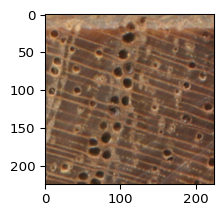

/usr/local/lib/python3.7/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.7/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/segmentation.py:272: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To di

In [9]:
image = imageio.imread(train_path + "MaSx/Ma1_3.tif")
print(image.shape)
print("Original:")
ia.imshow(image)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.


aug = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=False
)

BATCH_SIZE = 16
NB_BATCHES = 100

images = [np.copy(image) for _ in range(BATCH_SIZE)]
import time
from imgaug.augmentables.batches import UnnormalizedBatch
batches = [UnnormalizedBatch(images=images) for _ in range(NB_BATCHES)]
time_start = time.time()
batches_aug = list(aug.augment_batches(batches, background=True))  # background=True for multicore aug
time_end = time.time()

Augmentation done in 25.33s


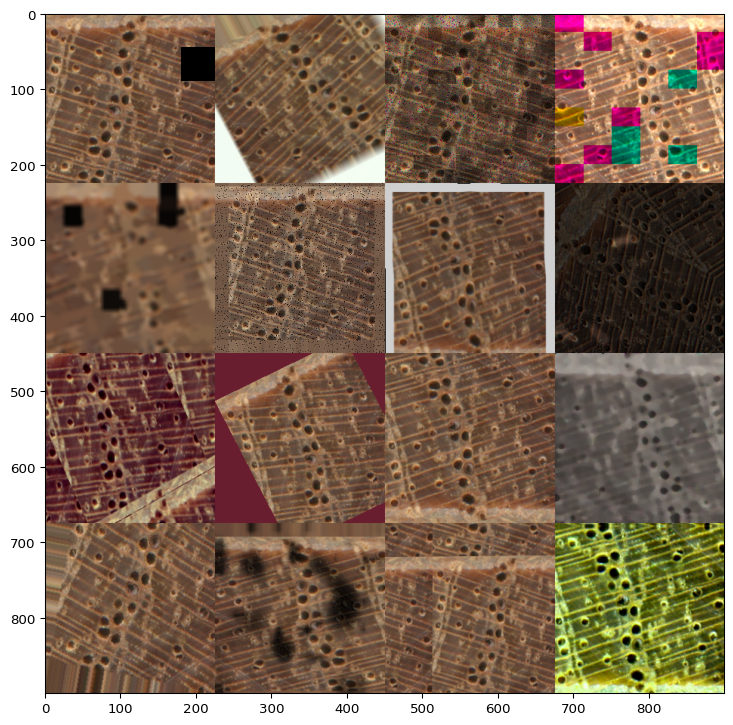

In [10]:
print("Augmentation done in %.2fs" % (time_end - time_start,))
ia.imshow(ia.draw_grid([batches_aug[0].images_aug[i] for i in range(16)]))

Original:


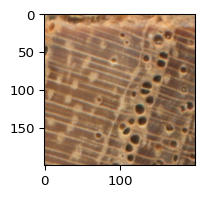

(200, 200, 3)
Augmented:


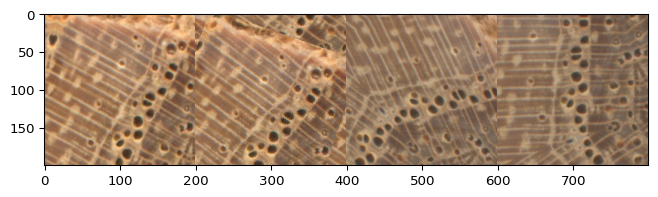

In [13]:
image = imageio.imread(test_path + "MaSx/Ma1_2.tif")
image = skimage.img_as_ubyte(skimage.transform.resize(image, (200, 200)))
print("Original:")
ia.imshow(image)

seq = iaa.Sequential([    
    iaa.SomeOf((4, 8), [
        iaa.Multiply((0.9, 1.2)),
        iaa.OneOf([
            iaa.Sometimes(0.3, iaa.UniformColorQuantization(n_colors=(16, 256)))
        ]),
        iaa.OneOf([
                iaa.Affine(
                    scale={"x": (0.9, 1.2), "y": (0.9, 1.2)}, # scale images to 90-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-45, 45), # rotate by -45 to +45 degrees
                    shear=(-10, 10), # shear by -10 to +10 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                ),
            ]),
        #iaa.CropAndPad(px=((0, 50)), pad_mode=ia.ALL, pad_cval=(0, 128)),
        iaa.LinearContrast((0.5, 1.5)),
        iaa.Sometimes(0.3, iaa.Sharpen(alpha=(0, 1.0), lightness=(1.0, 1.5))),
        #iaa.Sometimes(0.3, iaa.pillike.Autocontrast()),
        iaa.Sometimes(0.1, iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.2))),
        #iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=0.05*255)),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 1.5))),
], random_order=False)
], random_order=False)
images_aug = [seq(image=image) for _ in range(4)]

print(images_aug[0].shape)

print("Augmented:")
ia.imshow(ia.draw_grid(images_aug, cols=4, rows=1))

# 資料準備

有5類資料
MaSx, PcSx, TgSx, UpSx, ZzSx

找出training dataloader中圖片的mean和standard deviation，以方便後續正規化

In [14]:
input_size = (64, 64)

train_transforms = tt.Compose([
    tt.Resize(input_size),
    tt.RandomCrop(input_size),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
#    tt.Grayscale(num_output_channels=3),
    lambda x:np.transpose(x, (0, 1, 2)),
    iaa.Sequential([
        iaa.SomeOf((4, 8), [
        iaa.Multiply((0.9, 1.2)),
        iaa.OneOf([
            iaa.Sometimes(0.3, iaa.UniformColorQuantization(n_colors=(16, 256)))
        ]),
        iaa.OneOf([
                iaa.Affine(
                    scale={"x": (0.9, 1.2), "y": (0.9, 1.2)}, # scale images to 90-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-45, 45), # rotate by -45 to +45 degrees
                    shear=(-10, 10), # shear by -10 to +10 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                ),
            ]),
        #iaa.CropAndPad(px=((0, 50)), pad_mode=ia.ALL, pad_cval=(0, 128)),
        iaa.LinearContrast((0.5, 1.5)),
        iaa.Sometimes(0.3, iaa.Sharpen(alpha=(0, 1.0), lightness=(1.0, 1.5))),
        #iaa.Sometimes(0.3, iaa.pillike.Autocontrast()),
        iaa.Sometimes(0.1, iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.2))),
        #iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=0.05*255)),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 1.5))),
        #iaa.Sometimes(0.3, iaa.MotionBlur(k=(3, 7), angle=[0, 90])),
            ], random_order=True),
        ], random_order=False).augment_image,
    tt.ToTensor(),
])
train = ImageFolder(split_train_path, transform = train_transforms)
train_dl = DataLoader(train, 64, shuffle=True, num_workers=2, pin_memory=True)

def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0

    for data, _ in tqdm(dl):
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1
        
    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean,std

mean, std = get_mean_std(train_dl)
mean, std

  0%|          | 0/39 [00:00<?, ?it/s]

(tensor([0.5412, 0.3982, 0.2783]), tensor([0.1918, 0.1744, 0.1391]))


在從訓練資料集中載入圖像時應用隨機選擇轉換。

具體來說，即將每個圖像填充 4 個像素，然後隨機裁剪大小為 64 x 64 像素的圖像，並以 50% 的機率水平翻轉圖像。由於每次載入特定圖像時都會隨機且動態地應用轉換，因此模型在每個訓練階段看到的圖像略有不同，這使得它可以更好地試到不同的情形。

In [63]:
#(tensor([0.5217, 0.3845, 0.2694]), tensor([0.1870, 0.1702, 0.1370]))
#(tensor([0.5075, 0.3732, 0.2609]), tensor([0.1838, 0.1647, 0.1326]))
#(tensor([0.4840, 0.3532, 0.2439]), tensor([0.1775, 0.1581, 0.1263])
#(tensor([0.4820, 0.3784, 0.2932]), tensor([0.2095, 0.2013, 0.1974]))

stats = ((0.5412, 0.3982, 0.278), (0.1918, 0.1744, 0.1391))
input_size = (64, 64)

train_transforms = transforms.Compose([
    tt.Resize(input_size),
    tt.RandomCrop(input_size),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    #tt.Grayscale(num_output_channels=3),
    lambda x:np.transpose(x, (0, 1, 2)),
    iaa.Sequential([
        iaa.SomeOf((4, 8), [
        iaa.Multiply((0.9, 1.2)),
        iaa.OneOf([
            iaa.Sometimes(0.3, iaa.UniformColorQuantization(n_colors=(16, 256)))
        ]),
        iaa.OneOf([
                iaa.Affine(
                    scale={"x": (0.9, 1.2), "y": (0.9, 1.2)}, # scale images to 90-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-45, 45), # rotate by -45 to +45 degrees
                    shear=(-10, 10), # shear by -10 to +10 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                ),
            ]),
        #iaa.CropAndPad(px=((0, 50)), pad_mode=ia.ALL, pad_cval=(0, 128)),
        iaa.LinearContrast((0.5, 1.5)),
        iaa.Sometimes(0.3, iaa.Sharpen(alpha=(0, 1.0), lightness=(1.0, 1.5))),
        #iaa.Sometimes(0.3, iaa.pillike.Autocontrast()),
        iaa.Sometimes(0.1, iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.2))),
        #iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=0.05*255)),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 1.5))),
        #iaa.Sometimes(0.3, iaa.MotionBlur(k=(3, 7), angle=[0, 90])),
            ], random_order=True),
        ], random_order=False).augment_image,
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

val_transforms = transforms.Compose([
tt.Resize(input_size),
    tt.RandomCrop(input_size),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    #tt.Grayscale(num_output_channels=3),
    lambda x:np.transpose(x, (0, 1, 2)),
    iaa.Sequential([
#        iaa.SomeOf((4, 8), [
#        iaa.Multiply((0.9, 1.2)),
#        iaa.OneOf([
#            iaa.Sometimes(0.3, iaa.UniformColorQuantization(n_colors=(16, 256)))
#        ]),
#        iaa.OneOf([
#                iaa.Affine(
#                    scale={"x": (0.9, 1.2), "y": (0.9, 1.2)}, # scale images to 90-120% of their size, individually per axis
#                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
#                    rotate=(-45, 45), # rotate by -45 to +45 degrees
#                    shear=(-10, 10), # shear by -10 to +10 degrees
#                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
#                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
#                ),
#            ]),
#        #iaa.CropAndPad(px=((0, 50)), pad_mode=ia.ALL, pad_cval=(0, 128)),
#        iaa.LinearContrast((0.5, 1.5)),
#        iaa.Sometimes(0.3, iaa.Sharpen(alpha=(0, 1.0), lightness=(1.0, 1.5))),
#        #iaa.Sometimes(0.3, iaa.pillike.Autocontrast()),
#        iaa.Sometimes(0.1, iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.2))),
#        #iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=0.05*255)),
#        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 1.5))),
#        #iaa.Sometimes(0.3, iaa.MotionBlur(k=(3, 7), angle=[0, 90])),
#            ], random_order=True),
        ], random_order=False).augment_image,
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

test_transforms = transforms.Compose([
    tt.Resize((200, 200)),                                    
    tt.CenterCrop(input_size),
    #tt.Grayscale(num_output_channels=3),
    lambda x : np.transpose(x, (0, 1, 2)),
    iaa.Sequential([

    ]).augment_image,
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])


In [64]:
train = ImageFolder(train_path, transform = train_transforms)
test = ImageFolder(test_path,transform = test_transforms)

將資料集分成兩部分:
- train_ds: 訓練資料
- valid_ds: 測試資料(用於測試模型準確性，這將呈現模型在從未測試過的資料集上的表現）

In [17]:
random_seed = 42
torch.manual_seed(random_seed);

In [18]:
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(1986, 496)

接下來，我創建了用於批量檢索圖像的dataloader。我將使用相對較大的 128 批次大小來利用較大部分的 GPU RAM。

`Note ` 如果遇到“內存不足”錯誤，可以嘗試減小批次處理大小並重新啟動內核。

In [19]:
batch_size = 32

# PyTorch data loaders
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

讓我們稍微看一下training dataloader中的一些圖片。為了顯示圖片，我們需要對像素值進行反正規化，以讓範圍回到 (0,1) 內。

In [20]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

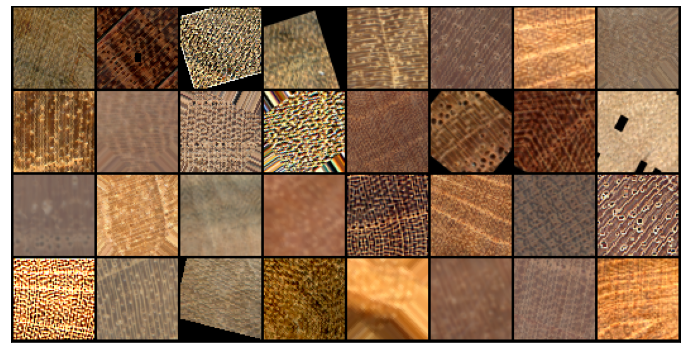

In [21]:
show_batch(train_dl)

### 一些好用的函數和類別

這裡定義了一些函數和類別來將資料搬移到 gpu 中，如此能大量節省訓練時間
另也有存log的函式


In [22]:
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)

    return logger

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

`ImageClassificationBase` 能計算loss並keep track of every epoch

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        logger.info("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

將資料移到 gpu 

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### 建立模型

這裡將延伸`ImageClassificationBase`以開發`ResNet9`模型，該模型由每兩個CNN層之後的`Residual Blocks`組成

In [27]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [28]:
no_of_classes = len(train.classes)
no_of_classes

5

In [29]:
model = to_device(ResNet9(3, no_of_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

tqdm 能顯示進度條，可以方便查看模型訓練進度

In [30]:
from tqdm.notebook import tqdm

現在準備好要訓練模型了

### 訓練模型

In [31]:
f = str(datetime.now())
temp = ROOT_DIR + '/log/' + f + 'imgaug_exp01.log'
logger = get_logger(temp)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
# just empty the cache in gpu
import torch
torch.cuda.empty_cache()

In [33]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.1809895783662796, 'val_loss': 1.6078581809997559}]

一開始，使用隨機權重，準確率為 17.76%

In [36]:
epochs = 30
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [37]:
%%time
logger.info('start training!')
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
logger.info('finish training!')

[2022-03-02 14:59:45,262][<timed exec>][line:1][INFO] start training!


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:00:09,587][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [0], last_lr: 0.00068, train_loss: 1.2323, val_loss: 1.0384, val_acc: 0.5573


Epoch [0], last_lr: 0.00068, train_loss: 1.2323, val_loss: 1.0384, val_acc: 0.5573


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:00:33,087][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [1], last_lr: 0.00151, train_loss: 0.9461, val_loss: 1.0961, val_acc: 0.5241


Epoch [1], last_lr: 0.00151, train_loss: 0.9461, val_loss: 1.0961, val_acc: 0.5241


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:00:56,667][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [2], last_lr: 0.00279, train_loss: 0.9313, val_loss: 1.1730, val_acc: 0.6478


Epoch [2], last_lr: 0.00279, train_loss: 0.9313, val_loss: 1.1730, val_acc: 0.6478


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:01:20,226][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [3], last_lr: 0.00435, train_loss: 0.9219, val_loss: 0.9496, val_acc: 0.6035


Epoch [3], last_lr: 0.00435, train_loss: 0.9219, val_loss: 0.9496, val_acc: 0.6035


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:01:44,137][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [4], last_lr: 0.00602, train_loss: 1.0986, val_loss: 0.7828, val_acc: 0.6380


Epoch [4], last_lr: 0.00602, train_loss: 1.0986, val_loss: 0.7828, val_acc: 0.6380


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:02:07,741][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [5], last_lr: 0.00759, train_loss: 1.0494, val_loss: 0.9885, val_acc: 0.5827


Epoch [5], last_lr: 0.00759, train_loss: 1.0494, val_loss: 0.9885, val_acc: 0.5827


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:02:31,239][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [6], last_lr: 0.00887, train_loss: 0.9009, val_loss: 0.7137, val_acc: 0.6562


Epoch [6], last_lr: 0.00887, train_loss: 0.9009, val_loss: 0.7137, val_acc: 0.6562


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:02:54,689][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [7], last_lr: 0.00971, train_loss: 0.9112, val_loss: 1.0975, val_acc: 0.6367


Epoch [7], last_lr: 0.00971, train_loss: 0.9112, val_loss: 1.0975, val_acc: 0.6367


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:03:18,196][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [8], last_lr: 0.01000, train_loss: 0.9993, val_loss: 0.7469, val_acc: 0.6888


Epoch [8], last_lr: 0.01000, train_loss: 0.9993, val_loss: 0.7469, val_acc: 0.6888


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:03:41,459][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [9], last_lr: 0.00994, train_loss: 0.8367, val_loss: 0.7058, val_acc: 0.6882


Epoch [9], last_lr: 0.00994, train_loss: 0.8367, val_loss: 0.7058, val_acc: 0.6882


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:04:04,936][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [10], last_lr: 0.00978, train_loss: 0.7460, val_loss: 0.6738, val_acc: 0.7090


Epoch [10], last_lr: 0.00978, train_loss: 0.7460, val_loss: 0.6738, val_acc: 0.7090


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:04:28,450][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [11], last_lr: 0.00950, train_loss: 0.7273, val_loss: 0.6532, val_acc: 0.7103


Epoch [11], last_lr: 0.00950, train_loss: 0.7273, val_loss: 0.6532, val_acc: 0.7103


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:04:58,068][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [12], last_lr: 0.00913, train_loss: 0.7917, val_loss: 0.6144, val_acc: 0.7370


Epoch [12], last_lr: 0.00913, train_loss: 0.7917, val_loss: 0.6144, val_acc: 0.7370


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:05:21,522][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [13], last_lr: 0.00867, train_loss: 0.6830, val_loss: 0.6768, val_acc: 0.6823


Epoch [13], last_lr: 0.00867, train_loss: 0.6830, val_loss: 0.6768, val_acc: 0.6823


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:05:44,957][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [14], last_lr: 0.00812, train_loss: 0.6822, val_loss: 0.7686, val_acc: 0.6738


Epoch [14], last_lr: 0.00812, train_loss: 0.6822, val_loss: 0.7686, val_acc: 0.6738


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:06:08,448][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [15], last_lr: 0.00750, train_loss: 0.6388, val_loss: 0.5790, val_acc: 0.7298


Epoch [15], last_lr: 0.00750, train_loss: 0.6388, val_loss: 0.5790, val_acc: 0.7298


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:06:32,064][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [16], last_lr: 0.00683, train_loss: 0.5872, val_loss: 0.5685, val_acc: 0.7533


Epoch [16], last_lr: 0.00683, train_loss: 0.5872, val_loss: 0.5685, val_acc: 0.7533


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:06:55,500][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [17], last_lr: 0.00611, train_loss: 0.5306, val_loss: 0.5345, val_acc: 0.7702


Epoch [17], last_lr: 0.00611, train_loss: 0.5306, val_loss: 0.5345, val_acc: 0.7702


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:07:19,023][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [18], last_lr: 0.00537, train_loss: 0.4939, val_loss: 0.6284, val_acc: 0.7559


Epoch [18], last_lr: 0.00537, train_loss: 0.4939, val_loss: 0.6284, val_acc: 0.7559


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:07:42,600][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [19], last_lr: 0.00463, train_loss: 0.5205, val_loss: 0.4783, val_acc: 0.8073


Epoch [19], last_lr: 0.00463, train_loss: 0.5205, val_loss: 0.4783, val_acc: 0.8073


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:08:06,146][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [20], last_lr: 0.00389, train_loss: 0.4210, val_loss: 0.3452, val_acc: 0.8698


Epoch [20], last_lr: 0.00389, train_loss: 0.4210, val_loss: 0.3452, val_acc: 0.8698


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:08:29,675][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [21], last_lr: 0.00317, train_loss: 0.4081, val_loss: 0.3859, val_acc: 0.8613


Epoch [21], last_lr: 0.00317, train_loss: 0.4081, val_loss: 0.3859, val_acc: 0.8613


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:08:53,098][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [22], last_lr: 0.00250, train_loss: 0.3925, val_loss: 0.3206, val_acc: 0.8835


Epoch [22], last_lr: 0.00250, train_loss: 0.3925, val_loss: 0.3206, val_acc: 0.8835


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:09:16,724][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [23], last_lr: 0.00188, train_loss: 0.3327, val_loss: 0.3227, val_acc: 0.8763


Epoch [23], last_lr: 0.00188, train_loss: 0.3327, val_loss: 0.3227, val_acc: 0.8763


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:09:40,331][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [24], last_lr: 0.00133, train_loss: 0.2965, val_loss: 0.2805, val_acc: 0.8867


Epoch [24], last_lr: 0.00133, train_loss: 0.2965, val_loss: 0.2805, val_acc: 0.8867


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:10:03,693][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [25], last_lr: 0.00087, train_loss: 0.2772, val_loss: 0.2531, val_acc: 0.9121


Epoch [25], last_lr: 0.00087, train_loss: 0.2772, val_loss: 0.2531, val_acc: 0.9121


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:10:27,252][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [26], last_lr: 0.00050, train_loss: 0.2469, val_loss: 0.2433, val_acc: 0.9082


Epoch [26], last_lr: 0.00050, train_loss: 0.2469, val_loss: 0.2433, val_acc: 0.9082


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:10:50,828][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [27], last_lr: 0.00022, train_loss: 0.2539, val_loss: 0.2203, val_acc: 0.9199


Epoch [27], last_lr: 0.00022, train_loss: 0.2539, val_loss: 0.2203, val_acc: 0.9199


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:11:17,048][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [28], last_lr: 0.00006, train_loss: 0.2317, val_loss: 0.2102, val_acc: 0.9258


Epoch [28], last_lr: 0.00006, train_loss: 0.2317, val_loss: 0.2102, val_acc: 0.9258


  0%|          | 0/78 [00:00<?, ?it/s]

[2022-03-02 15:11:40,573][<ipython-input-24-e293dd220bfa>][line:30][INFO] Epoch [29], last_lr: 0.00000, train_loss: 0.2237, val_loss: 0.2433, val_acc: 0.9030
[2022-03-02 15:11:40,579][<timed exec>][line:6][INFO] finish training!


Epoch [29], last_lr: 0.00000, train_loss: 0.2237, val_loss: 0.2433, val_acc: 0.9030
CPU times: user 3min 29s, sys: 1min 51s, total: 5min 21s
Wall time: 11min 55s


模型在 15 分鐘內訓練到超過 90% 的準確率！

可以再嘗試使用數據增強、網路架構調整和超參數來獲得更好的結果

繪製驗證集準確度來查看模型如何隨著時間的推移而改進。

In [38]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-o')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Accuracy vs. No. of epochs');

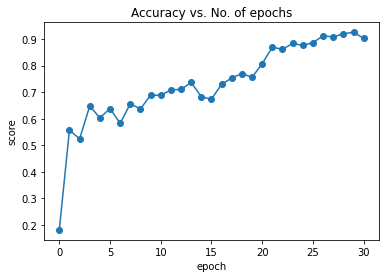

In [39]:
plot_scores(history)

還可以繪製訓練和驗證損失來查看趨勢。

In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

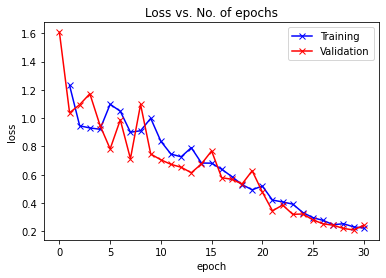

In [41]:
plot_losses(history)

從趨勢中可以清楚地看出，模型還沒有過度擬合訓練數據。

最後，視覺化 學習率是如何在所有 epoch 中逐批地隨時間變化的，。

In [42]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

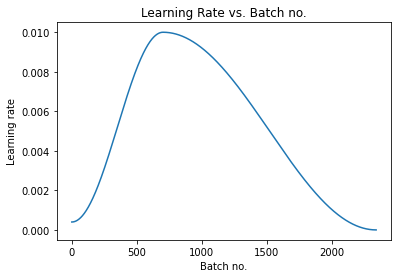

In [43]:
plot_lrs(history)

正如預期的那樣，學習率從一個低值開始，在 90 的迭代中逐漸增加到最大值 0.01，然後逐漸減小到一個非常小的值。

# 預測未測試與訓練過的資料

In [44]:
PRED_DIR = DATA_DIR + '/pred/pred/'

從預測資料集中隨機選擇圖像。

In [45]:
random_filename = random.choice([
    x for x in os.listdir(PRED_DIR)
    if os.path.isfile(os.path.join(PRED_DIR, x))
])

random_filename

'Ma2_3.tif'

將之前應用於訓練資料的相同轉換(transform)應用於此圖像

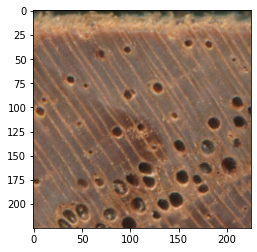

In [46]:
image = Image.open(PRED_DIR+random_filename)  
image = tt.ToTensor()(image)
plt.imshow(image.permute(1, 2, 0))
image = tt.Normalize(*stats,inplace=True)(image)

In [47]:
def predict_single(image):
    xb = image
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", decode_target(prediction, text_labels=True))
    plt.imshow(image.squeeze().permute(1, 2, 0))

In [48]:
def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

[2022-03-02 15:12:15,475][image.py][line:709][WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  MaSx(0)


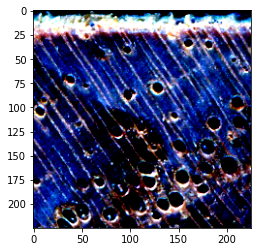

In [49]:
predict_single(image.unsqueeze(0))

In [50]:
# Save the model
torch.save(model.state_dict(), 'image-classifier-resnet9-imgaug-epoch30.pth')

### 混淆矩陣

先載入model

In [54]:
model.load_state_dict(torch.load('image-classifier-resnet9-imgaug-epoch30.pth'));

In [55]:
device = get_default_device()
device

device(type='cuda')

In [56]:
def predict(test_set, model):
    
    y_pred = []
    y_true = []
    
    model.to(device).eval()
    
    test_loader = DataLoader(test_set, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
    
    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images = images.to(device)
            target = target.to(device)
            output = model(images)
            _, preds = torch.max(output, 1)
            
            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(target.view(-1).detach().cpu().numpy())
        
    return y_pred, y_true

In [57]:
def plot_matrix(cm, classes):

    fig, ax= plt.subplots(figsize = (5, 4))
    sns.heatmap(cm, fmt='.2%', cmap="OrRd", annot=True, vmax=1, ax=ax)
    ax.set_yticklabels(classes, rotation=0)
    ax.set_xticklabels(classes, rotation=90)
    plt.show()

In [59]:
train_pred, train_label,  = predict(train_ds, model)
val_pred, val_label = predict(val_ds, model)
test_pred, test_label = predict(test, model)

Training acc.: 92.95 %


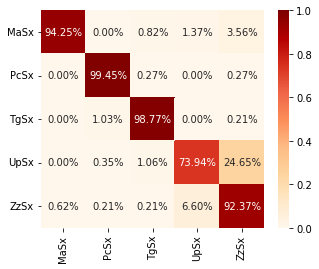

In [60]:
print("Training acc.: {:.2f} %".format(accuracy_score(train_label, train_pred)*100))
plot_matrix(confusion_matrix(train_label, train_pred, normalize='true'), classes=train.classes)

Validation acc.: 91.73 %


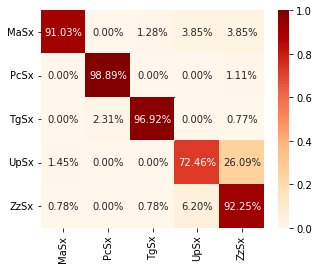

In [61]:
print("Validation acc.: {:.2f} %".format(accuracy_score(val_label, val_pred)*100))
plot_matrix(confusion_matrix(val_label, val_pred, normalize='true'), classes=train.classes)

Test acc.: 57.41 %


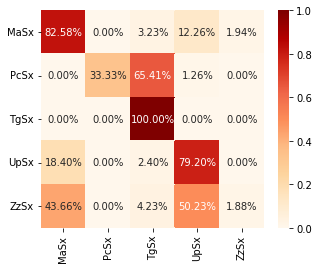

In [62]:
print("Test acc.: {:.2f} %".format(accuracy_score(test_label, test_pred)*100))
plot_matrix(confusion_matrix(test_label, test_pred, normalize='true'), classes=train.classes)